## MMTHE01 - Masters Thesis

### C. Thesis - Create a working model - without SMOTE
* Splitting the data into train and test data
* Feature scaling
* Model training

#### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder

In [2]:
### Import libraries to save models
import pickle
from tensorflow.keras.models import Model, load_model

In [3]:
# Check your current working directory
cwd = os.getcwd()

# Define your relative path
relative_path = r"6. Analysis"  # adjust this relative to cwd

# Build the full path
full_path = os.path.join(cwd, relative_path)

# Check if it exists before changing
if os.path.exists(full_path):
    os.chdir(full_path)
    print("Changed directory to:", full_path)
else:
    print("Folder does not exist:", full_path)

Changed directory to: C:\Users\eaber\Documents\11. Masters Thesis Final\6. Analysis


#### Importing the dataset

In [4]:
with open("saved_data/train_dataset_final_encoded.pkl","rb") as f:
    dataset = pickle.load(f)
#dataset = pd.read_csv('train_dataset_final_encoded.csv')

In [5]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,C3,C9,C12,C13,C14,TransactionID,...,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,86400,68.5,13926,0.0,1.0,0.0,1.0,1.0,2987000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,86401,29.0,2755,0.0,0.0,0.0,1.0,1.0,2987001,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,86469,59.0,4663,0.0,1.0,0.0,1.0,1.0,2987002,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,86499,50.0,18132,0.0,1.0,0.0,25.0,1.0,2987003,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,86506,50.0,4497,0.0,0.0,0.0,1.0,1.0,2987004,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
dataset.shape

(590540, 201)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 201 entries, isFraud to M4_M2
dtypes: float64(179), int64(8), object(14)
memory usage: 905.6+ MB


In [8]:
for col in dataset.columns:
    if dataset[col].dtype == "object":
        try:
            dataset[col] = pd.to_numeric(dataset[col])
        except:
            pass

In [9]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,C3,C9,C12,C13,C14,TransactionID,...,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,86400,68.5,13926,0.0,1.0,0.0,1.0,1.0,2987000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,86401,29.0,2755,0.0,0.0,0.0,1.0,1.0,2987001,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,86469,59.0,4663,0.0,1.0,0.0,1.0,1.0,2987002,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,86499,50.0,18132,0.0,1.0,0.0,25.0,1.0,2987003,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,86506,50.0,4497,0.0,0.0,0.0,1.0,1.0,2987004,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 201 entries, isFraud to M4_M2
dtypes: float64(193), int64(8)
memory usage: 905.6 MB


### 3.1 Split the data into Train-Test

#### 3.1.1 Separate the features and the label

In [11]:
dataset_final = dataset.drop('TransactionID', axis=1)

In [12]:
X = dataset_final.iloc[:, 1:].values
y = dataset_final.iloc[:,0].values

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

### 3.2 Feature Scaling

#### 3.2.1 Checking if the data has outliers

In [15]:
# Detect outliers using IQR method for each column
def detect_iqr_outliers(df):
    outlier_flags = pd.DataFrame(False, index=df.index, columns=df.columns)

    for col in df.select_dtypes(include=[int, float]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Mark outliers
        outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outlier_flags

In [16]:
# Call the function
outliers_df = detect_iqr_outliers(dataset)

In [17]:
outlier_count_df = outliers_df.apply(lambda col: col.value_counts()).T

In [18]:
outlier_count_df.to_csv('outlier_count_df.csv')

#### 3.2.2 Feature Scaling

In [19]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### 3.3 Baseline Model
* The logistic model is a weighted sum based model

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
# Build a LogisticRegression Base model
logR = LogisticRegression(random_state=1)

In [23]:
start_time = time.time()

In [24]:
# Train the LogisticRegression Base model
logR.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [25]:
end_time = time.time()
training_time = end_time - start_time
print(f"LR Base Model Training Time: {training_time:.2f} seconds")

LR Base Model Training Time: 5.36 seconds


In [26]:
# Predict y given X_test_scaled
y_pred = logR.predict(X_test_scaled)
y_pred_proba = logR.predict_proba(X_test_scaled)

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("LR Base Model AUC (in %):", auc_score*100)

LR Base Model AUC (in %): 84.66907864503291


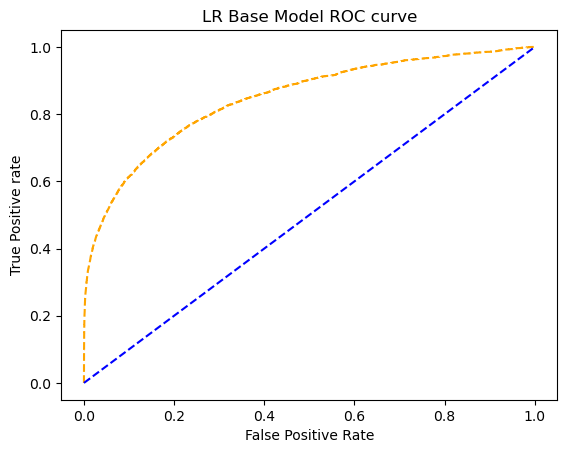

In [28]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('LR Base Model ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('LR Base Model ROC curve',dpi=300)
plt.show()

In [29]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"LR Base Model Recall Score (Sensitivity): {sensitivity:.4f}")

LR Base Model Recall Score (Sensitivity): 0.2165


In [30]:
### Calculate precision_score of the baseline model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"LR Base Model Precision Score: {precision:.4f}")

LR Base Model Precision Score: 0.8241


### 3.4 Unsupervised Learning Models

#### 3.4.1 Isolation Forest

In [31]:
from sklearn.ensemble import IsolationForest

In [32]:
# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.035,  # Approximate fraud ratio in dataset
    max_samples='auto',
    random_state=1,
    n_jobs=-1
)

In [33]:
start_time = time.time()

In [34]:
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.035, n_jobs=-1, random_state=1)

In [35]:
end_time = time.time()
training_time = end_time - start_time
print(f"Isolation Forest Training Time: {training_time:.2f} seconds")

Isolation Forest Training Time: 12.63 seconds


In [36]:
# Predict: -1 for outliers (fraud), 1 for inliers (non-fraud)
y_pred = iso_forest.predict(X_test_scaled)

In [37]:
# Convert to 1 for fraud, 0 for non-fraud to match label
y_pred_binary = np.where(y_pred == -1, 1, 0)

In [38]:
# Use anomaly scores for ROC AUC
y_pred_proba = iso_forest.decision_function(X_test_scaled)*-1  # Higher score = more anomalous

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("Isolation Forest AUC (in %):", auc_score*100)

Isolation Forest AUC (in %): 78.17976295628141


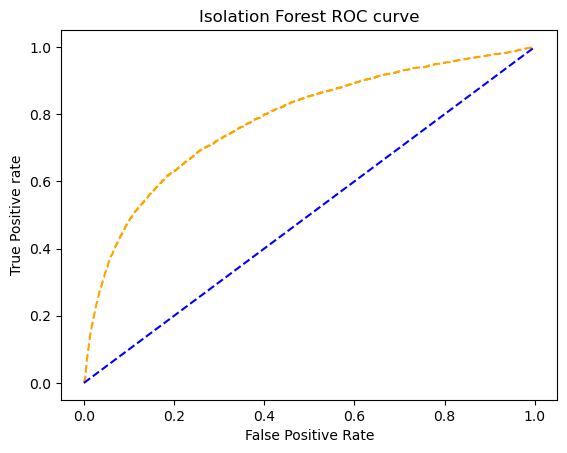

In [40]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Isolation Forest ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Isolation Forest ROC curve',dpi=300)
plt.show()

In [41]:
### Calculate recall_score of the Isolation Forest to determine its sensitivity

sensitivity = recall_score(y_test, y_pred_binary, pos_label=1)
print(f"Isolation Forest Recall Score (Sensitivity): {sensitivity:.4f}")

Isolation Forest Recall Score (Sensitivity): 0.2359


In [42]:
### Calculate precision_score of the Isolation Forest to determine its sensitivity

precision = precision_score(y_test, y_pred_binary, pos_label=1)
print(f"Isolation Forest Precision Score: {precision:.4f}")

Isolation Forest Precision Score: 0.2335


In [43]:
# save model
with open("saved_models/iso_forest_model_nonSMOTE.pkl", "wb") as f:
    pickle.dump(iso_forest, f)

#### 3.4.2 Autoencoder

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [45]:
# NOTE: Training is done on only on non-fraudulent samples
X_train_ae = X_train_scaled[y_train == 0] 

In [46]:
# Build the autoencoder
input_dim = X_train_ae.shape[1]
encoding_dim = 32  # compressed representation size

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)

decoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [47]:
start_time = time.time()

In [48]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=0
)

In [49]:
end_time = time.time()
training_time = end_time - start_time
print(f"Autoencoder Training Time: {training_time:.2f} seconds")

Autoencoder Training Time: 470.49 seconds


In [50]:
# Compute reconstruction errors on test data
X_test_pred = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [51]:
# Evaluate anomaly detection performance
# A simple threshold for anomaly score
threshold = np.percentile(mse[y_test == 0], 95)  # 95th percentile of reconstruction error on non-fraud

In [52]:
# Predict fraud if reconstruction error > threshold
y_pred = (mse > threshold).astype(int)

In [53]:
y_pred_proba = mse

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("Autoencoder AUC (in %):", auc_score*100)

Autoencoder AUC (in %): 76.54992300056888


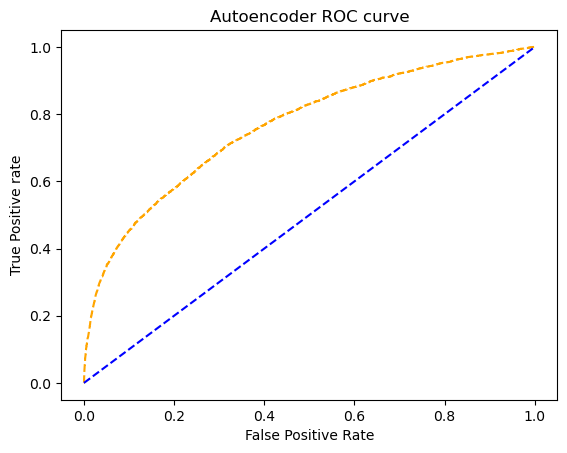

In [55]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Autoencoder ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Autoencoder ROC curve',dpi=300)
plt.show()

In [56]:
### Calculate recall_score of the Autoencoder to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"Autoencoder Recall Score (Sensitivity): {sensitivity:.4f}")

Autoencoder Recall Score (Sensitivity): 0.3467


In [57]:
### Calculate precision_score of the Autoencoder

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"Autoencoder Precision Score: {precision:.4f}")

Autoencoder Precision Score: 0.2009


In [58]:
autoencoder.save("saved_models/autoencoder_model_nonSMOTE.keras")

### 3.5 Supervised Learning Models

#### 3.5.1 Random Forest (RF)

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
# Build a Random Forest Model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight='balanced')

In [61]:
start_time = time.time()

In [62]:
# Train the Random Forest Model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=1)

In [63]:
end_time = time.time()
training_time = end_time - start_time
print(f"Random Forest Training Time: {training_time:.2f} seconds")

Random Forest Training Time: 339.11 seconds


In [64]:
# Predict y given X_test
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("Random Forest AUC (in %):", auc_score*100)

Random Forest AUC (in %): 88.93075220406459


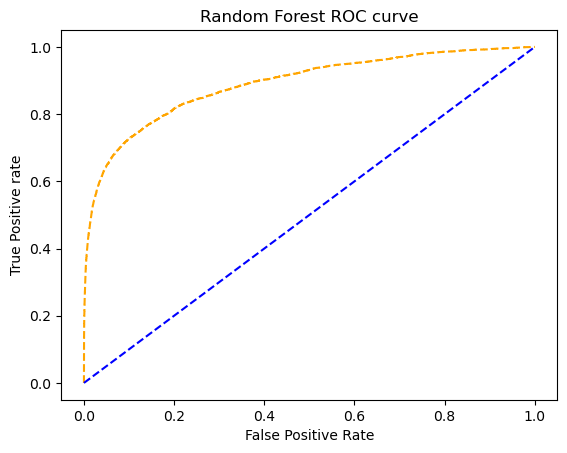

In [66]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Random Forest ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Random Forest ROC curve',dpi=300)
plt.show()

In [67]:
### Calculate recall_score of the Random Forest to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"Random Forest Recall Score (Sensitivity): {sensitivity:.4f}")

Random Forest Recall Score (Sensitivity): 0.7489


In [68]:
### Calculate precision_score of the Random Forest

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"Random Forest Precision Score: {precision:.4f}")

Random Forest Precision Score: 0.1800


In [69]:
# Save model
with open("saved_models/random_forest_model_nonSMOTE.pkl", "wb") as f:
    pickle.dump(rf, f)

#### 3.5.2 XGBoost

In [70]:
from xgboost import XGBClassifier

In [71]:
# Build an XGBoost Model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5,  # Adjust based on imbalance
    eval_metric='auc',
    random_state=1
)

In [72]:
start_time = time.time()

In [73]:
# Train the XGBoost model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [74]:
end_time = time.time()
training_time = end_time - start_time
print(f"XGBoost Training Time: {training_time:.2f} seconds")

XGBoost Training Time: 12.36 seconds


In [75]:
# Predict y given X_test
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("XGBoost AUC (in %):", auc_score*100)

XGBoost AUC (in %): 92.11676560250164


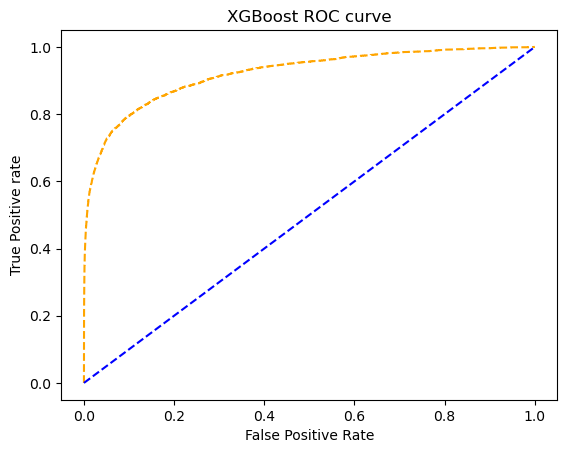

In [77]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('XGBoost ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('XGBoost ROC curve',dpi=300)
plt.show()

In [78]:
### Calculate recall_score of the XGBoost model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"XGBoost Recall Score (Sensitivity): {sensitivity:.4f}")

XGBoost Recall Score (Sensitivity): 0.5575


In [79]:
### Calculate precision_score of the XGBoost Model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"XGBoost Precision Score: {precision:.4f}")

XGBoost Precision Score: 0.6402


In [80]:
# Save model (JSON is preferred, supports portability)
xgb.save_model("saved_models/xgb_model_nonSMOTE.json")

#### 3.5.3 Artificial Neural Network (ANN)

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [82]:
# Build an ANN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer instead of input_dim in Dense
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_AUC', patience=3, restore_best_weights=True, mode='max')

In [83]:
start_time = time.time()

In [84]:
# Train the ANN model with timing
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=0
)

In [85]:
end_time = time.time()
training_time = end_time - start_time
print(f"ANN Training Time: {training_time:.2f} seconds")

ANN Training Time: 141.80 seconds


In [86]:
# Predict y given X_test_scaled
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [87]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("ANN AUC (in %):", auc_score*100)

ANN AUC (in %): 89.63689534005503


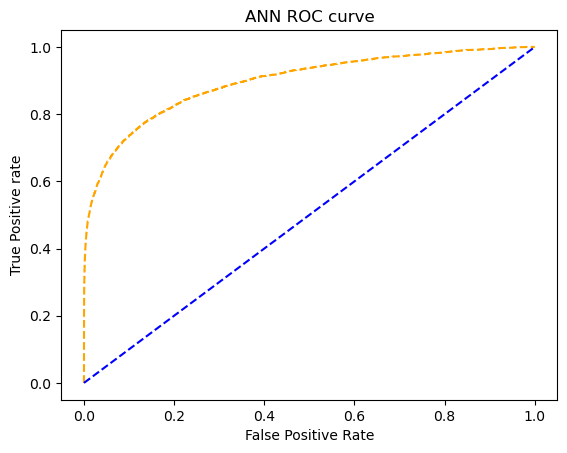

In [88]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ANN ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('ANN ROC curve',dpi=300)
plt.show()

In [89]:
### Calculate recall_score of the ANN model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"ANN Recall Score (Sensitivity): {sensitivity:.4f}")

ANN Recall Score (Sensitivity): 0.3499


In [90]:
### Calculate precision_score of the ANN model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"ANN Precision Score {precision:.4f}")

ANN Precision Score 0.8888


In [91]:
# Save ANN
model.save("saved_models/ann_model_nonSMOTE.keras")

#### 3.5.4 K Nearest Neighbour (KNN)

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
# Build a KNN model
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

In [94]:
start_time = time.time()

In [95]:
# Train the KNN model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [96]:
end_time = time.time()
training_time = end_time - start_time
print(f"KNN Training Time: {training_time:.2f} seconds")

KNN Training Time: 0.46 seconds


In [97]:
# Predict y given X_test_scaled
y_pred = knn.predict(X_test_scaled)
y_pred_proba = knn.predict_proba(X_test_scaled)

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("KNN AUC (in %):", auc_score*100)

KNN AUC (in %): 85.40351560238221


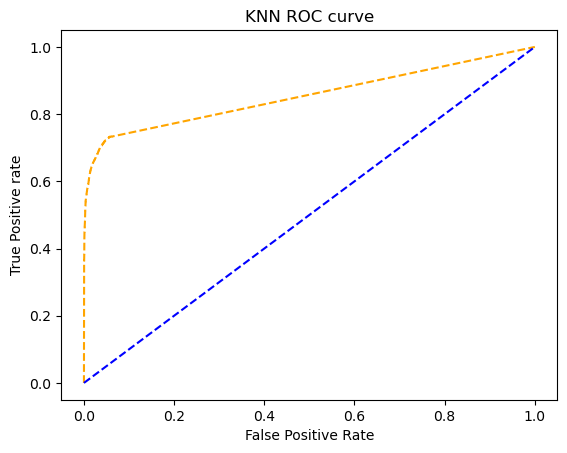

In [99]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('KNN ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('KNN ROC curve',dpi=300)
plt.show()

In [100]:
### Calculate recall_score of the KNN model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"KNN Recall Score (Sensitivity): {sensitivity:.4f}")

KNN Recall Score (Sensitivity): 0.5001


In [101]:
### Calculate precision_score of the KNN model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"KNN Precision Score (Sensitivity): {precision:.4f}")

KNN Precision Score (Sensitivity): 0.8740


In [102]:
# Save model
with open("saved_models/knn_model_nonSMOTE.pkl", "wb") as f:
    pickle.dump(knn, f)

#### 3.5.5 Support Vector Machine (SVM) - Linear SVC

In [103]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [104]:
# Define pipeline with scaling + LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(class_weight='balanced', max_iter=10000, random_state=42))
])

In [105]:
start_time = time.time()

In [106]:
# Fit the model
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=10000,
                           random_state=42))])

In [107]:
end_time = time.time()
training_time = end_time - start_time
print(f"SVM Base Model Training Time: {training_time:.2f} seconds")

SVM Base Model Training Time: 175.70 seconds


In [108]:
# Predict y given X_test_scaled
y_pred = pipeline.predict(X_test_scaled)
y_pred_proba = pipeline.decision_function(X_test_scaled)

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("SVM AUC (in %):", auc_score*100)

SVM AUC (in %): 85.20166197979476


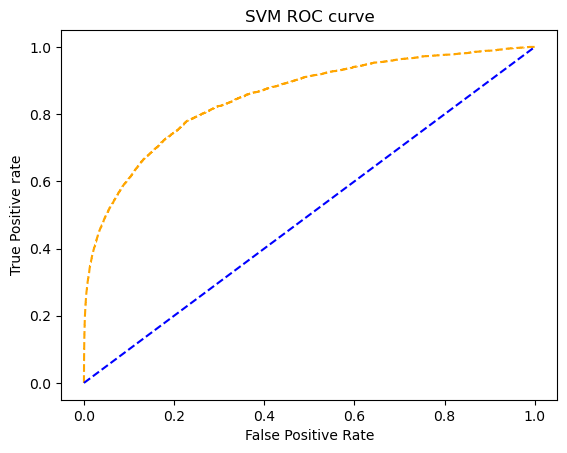

In [110]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('SVM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('SVM ROC curve',dpi=300)
plt.show()

In [111]:
### Calculate recall_score of the SVM model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"SVM Recall Score (Sensitivity): {sensitivity:.4f}")

SVM Recall Score (Sensitivity): 0.7293


In [112]:
### Calculate precision_score of the SVM model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"SVM Precision Score {precision:.4f}")

SVM Precision Score 0.1255


In [113]:
# Save model
with open("saved_models/svm_pipeline_nonSMOTE.pkl", "wb") as f:
    pickle.dump(pipeline, f)

#### 3.5.6 Gradient Boosting Machine (GBM)

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

In [115]:
# Define GBM model
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=1
)

In [116]:
start_time = time.time()

In [117]:
gbm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=1, subsample=0.8)

In [118]:
end_time = time.time()
training_time = end_time - start_time
print(f"GBM Training Time: {training_time:.2f} seconds")

GBM Training Time: 4025.19 seconds


In [119]:
# Predict y given X_test
y_pred = gbm.predict(X_test)
y_pred_proba = gbm.predict_proba(X_test)

In [120]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("GBM AUC (in %):", auc_score*100)

GBM AUC (in %): 89.11876827233888


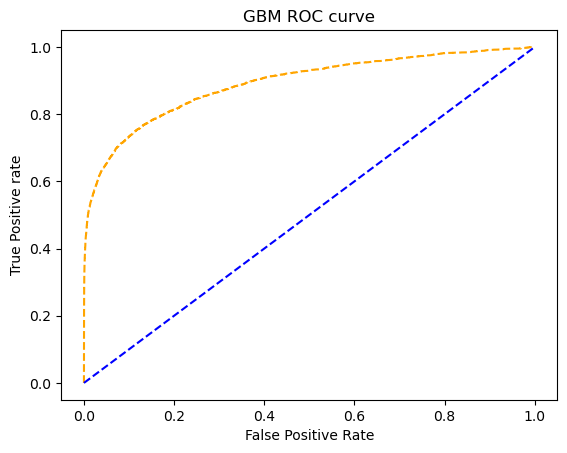

In [121]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('GBM ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('GBM ROC curve',dpi=300)
plt.show()

In [122]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"GBM Recall Score (Sensitivity): {sensitivity:.4f}")

GBM Recall Score (Sensitivity): 0.3605


In [123]:
### Calculate precision_score of the SVM model

precision = precision_score(y_test, y_pred, pos_label=1)
print(f"GBM Precision Score {precision:.4f}")

GBM Precision Score 0.8954


In [124]:
# Save model
with open("saved_models/gbm_model_nonSMOTE.pkl", "wb") as f:
    pickle.dump(gbm, f)